In [4]:
import numpy as np
import pathlib
import time
import sys
import os
import matplotlib
import pandas as pd
from dataclasses import asdict
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import functools
from pvtrace.light.utils import wavelength_to_rgb
from pvtrace.scene.scene import Scene
from pvtrace.trace.tracer import PhotonTracer
from pvtrace.scene.node import Node
from pvtrace.scene.node import Node
from pvtrace.common.errors import TraceError
from pvtrace.light.light import Light
from pvtrace.light.ray import Ray
from pvtrace.geometry.mesh import Mesh
from pvtrace.geometry.box import Box
from pvtrace.geometry.sphere import Sphere
from pvtrace.material.material import Dielectric, LossyDielectric, Lumophore, Host
from pvtrace.scene.node import Node
from pvtrace.scene.renderer import MeshcatRenderer
from pvtrace.geometry.utils import magnitude
import logging
# We want to see pvtrace logging here
logging.getLogger('pvtrace').setLevel(logging.ERROR)

# Luminescent solar concentrator

In this example we perform a simulation of a box shape luminescent concentrator (LSC) and demonstrate how the data can be analyised and plotted.

## Absorption and emission spectrum

Let's make a dye with an absorption coefficient (1/cm) and an emission spectrum. In a real simulation you will want to use measured data for this properties.

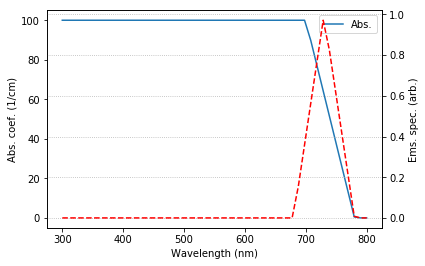

In [5]:
def make_absorprtion_coefficient(wavelengths, absorption_coefficient, cutoff_range, min_alpha=0):
    wavelength1, wavelength2 = cutoff_range
    alpha = absorption_coefficient
    halfway = wavelength1 + 0.5 * (wavelength2 - wavelength1)
    x = [0.0, wavelength1, halfway, wavelength2, sys.float_info.max]
    y = [alpha, alpha, 0.5 * alpha, min_alpha, min_alpha]
    abs_coeff = np.interp(wavelengths, x, y)
    return abs_coeff

def make_emission_spectrum(wavelengths, cutoff_range, min_ems=0):
    wavelength1, wavelength2 = cutoff_range
    halfway = wavelength1 + 0.5 * (wavelength2 - wavelength1)
    x = [0.0, wavelength1, halfway, wavelength2, sys.float_info.max]
    y = [min_ems, min_ems, 1.0, min_ems, min_ems]
    abs_coeff = np.interp(wavelengths, x, y)
    return abs_coeff

wavelength_range = (300, 800)
wavelength = np.linspace(*wavelength_range)
abs_coef = make_absorprtion_coefficient(wavelength, 100.0, (700, 780))
ems_spec = make_emission_spectrum(wavelength, (680, 780))
fig, ax1 = plt.subplots()
ax1.plot(wavelength, abs_coef, label="Abs.")
ax1.set_ylabel('Abs. coef. (1/cm)')
ax2 = ax1.twinx()
ax2.plot(wavelength, ems_spec, '--r', label="Ems.")
ax2.set_ylabel('Ems. spec. (arb.)')
ax1.set_xlabel('Wavelength (nm)')
plt.grid(linestyle='dotted')
ax1.legend()

We need to provide this data to pvtrace in a pandas dataframe with a very specific format as shown below,

In [9]:
data = {
    "wavelength": wavelength,
    "refractive index": np.ones(wavelength.shape) * 1.5,
    "absorption coefficient dye 1": abs_coef,
    "emission spectrum dye 1": ems_spec,
    "quantum yield dye 1": np.ones(wavelength.shape) * 1.0
}    
df = pd.DataFrame(data)
df.tail()

,wavelength,refractive index,absorption coefficient dye 1,emission spectrum dye 1,quantum yield dye 1
45,759.183673,1.5,26.020408,0.416327,1.0
46,769.387755,1.5,13.265306,0.212245,1.0
47,779.591837,1.5,0.510204,0.008163,1.0
48,789.795918,1.5,0.000000,0.000000,1.0
49,800.000000,1.5,0.000000,0.000000,1.0


## LSC scene

Let's make our scene. If you have followed the tutorials 001 to 004 all of the following should make sense,

In [10]:
# Make a world coordinate system
world_node = Node(name='world')
world_node.geometry = Sphere(radius=10.0, material=Dielectric.make_constant((300, 1000.0), 1.0))

# Add LSC
size = (1.0, 1.0, 0.02)
lsc = Node(name="LSC", parent=world_node)
lsc.geometry = Box(size, material=Host.from_dataframe(df))

# Light source
light = Light(divergence_delegate=functools.partial(Light.cone_divergence, np.radians(20)))
light_node = Node(name='light', parent=world_node, location=(0.0, 0.0, 1.0))
light_node.rotate(np.radians(180), (1, 0, 0))
light_node.light = light
scene = Scene(root=world_node)

In [11]:
renderer = MeshcatRenderer(max_histories=None)
renderer.render(scene)
renderer.vis.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7004/static/


Let's trace a small number of rays to see if we made our scene correctly.

In [12]:
tracer = PhotonTracer(scene)
for light_node in scene.light_nodes:
    for ray in light.emit(20):
        ray = ray.representation(light_node, world_node)
        history = tracer.follow(ray)
        path = [x for x in history]
        renderer.add_ray_path(path)

## Tracing

The scene looks good, we have a divergent light source with wavelength 555nm hitting the top surface and luminescent rays are exiting the LSC surface.

Let's trace a larger number of rays to make a dataset we can analyse.

In [13]:
from ipywidgets import IntProgress
from IPython.display import display
np.random.seed(4)
tracer = PhotonTracer(scene)
entrance_rays = []
exit_rays = []
max_rays = 200
f = IntProgress(min=0, max=max_rays, description='Tracing:',
)
display(f)
for light_node in scene.light_nodes:
    for idx, ray in enumerate(light.emit(max_rays)):
        ray = ray.representation(light_node, world_node)
        try:
            path = tracer.follow(ray)
        except TraceError:
            continue
        else:
            entrance_rays.append(path[0])
            exit_rays.append(path[-2])  # -1 is the world node, don't want that
        finally:
            f.value += 1
print("Done!")

IntProgress(value=0, description='Tracing:', max=200)

Done!



Here are some helper functions for labelling and processing the row and columns.

In [14]:
def expand_coords(df, column):
    """ Returns a dataframe with coordinate column expanded into components.
    
        Parameters
        ----------
        df : pandas.DataFrame
            The dataframe
        column : str
            The column label
        
        Returns
        -------
        df : pandas.DataFrame
            The dataframe with the column expanded.
        
        Example
        -------
        Given the dataframe::
        
            df = pd.DataFrame({'position': [(1,2,3)]})
        
        the function will return a new dataframe::
        
            edf = expand_coords(df, 'position')
            edf == pd.DataFrame({'position_x': [1], 'position_y': [2], 'position_z': [3]})
        
    """
    coords = np.stack(df[column].values)
    df['{}_x'.format(column)] = coords[:, 0]
    df['{}_y'.format(column)] = coords[:, 1]
    df['{}_z'.format(column)] = coords[:, 2]
    df.drop(columns=column, inplace=True)
    return df

def label_facets(df, length, width, height):
    """ Label rows with facet names for a box LSC.
    
        Notes
        -----
        This function only works if the coordinates in the dataframe
        are in the local frame of the box. If the coordinates are in the
        world frame then this will still work provided the box is axis
        aligned with the world node and centred at the origin.
    """
    xmin, xmax = -0.5*length, 0.5*length
    ymin, ymax = -0.5*width, 0.5*width
    zmin, zmax = -0.5*height, 0.5*height
    df.loc[(np.isclose(df['position_x'], xmin)), 'facet'] = '-x'
    df.loc[(np.isclose(df['position_x'], xmax)), 'facet'] = '+x'
    df.loc[(np.isclose(df['position_y'], ymin)), 'facet'] = '-y'
    df.loc[(np.isclose(df['position_y'], ymax)), 'facet'] = '+y'
    df.loc[(np.isclose(df['position_z'], zmin)), 'facet'] = '-z'
    df.loc[(np.isclose(df['position_z'], zmax)), 'facet'] = '+z'
    return df



Let's investigate the entrance and exit rays.

In [15]:
df = pd.DataFrame()

# Rays entering the scene
for ray in entrance_rays:
    rep = asdict(ray)
    rep['kind'] = 'entrance'
    df = df.append(rep, ignore_index=True)
    
# Rays exiting the scene
for ray in exit_rays:
    rep = asdict(ray)
    rep['kind'] = 'exit'
    df = df.append(rep, ignore_index=True)
    
# Expand position and direction columns into component columns
df = expand_coords(df, 'direction')
df = expand_coords(df, 'position')

# Label facets
df = label_facets(df, *size)
df.head()

,is_alive,kind,wavelength,direction_x,direction_y,direction_z,position_x,position_y,position_z,facet
0,1.0,entrance,555.0,0.227126,0.047736,-0.972695,0.0,0.0,1.0,NaN
1,1.0,entrance,555.0,0.249028,0.069553,-0.965995,0.0,0.0,1.0,NaN
2,1.0,entrance,555.0,-0.012284,0.111872,-0.993647,0.0,0.0,1.0,NaN
3,1.0,entrance,555.0,-0.006309,0.074203,-0.997223,0.0,0.0,1.0,NaN
4,1.0,entrance,555.0,-0.078255,-0.011462,-0.996868,0.0,0.0,1.0,NaN


## Spatial distribution of photons

Let's view all rays locations in the xy-plane

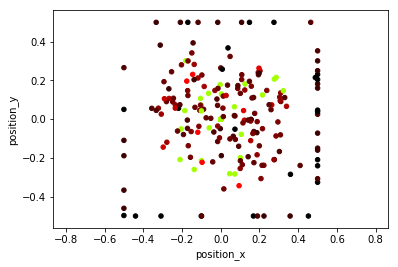

In [16]:
def xy_plot(df):
    """ Plots ray positions in the xy-plane.
        
        References
        ----------
        [1] https://stackoverflow.com/questions/44959955/matplotlib-color-under-curve-based-on-spectral-color
    """
    norm = plt.Normalize(*wavelength_range)
    wl = np.arange(wavelength_range[0], wavelength_range[1]+1,2)
    colorlist = list(zip(norm(wl), [np.array(wavelength_to_rgb(w))/255 for w in wl]))
    spectralmap = matplotlib.colors.LinearSegmentedColormap.from_list("spectrum", colorlist)
    colors = [spectralmap(norm(value)) for value in df['wavelength']]
    df.plot(x='position_x', y='position_y', kind='scatter', alpha=1.0, color=colors)
    plt.axis('equal')
xy_plot(df)

We can see the green rays entering the top surface. Rays near the centre are redshifted from green to red because they have only travelled a short distance and have not encounted many reabsorption event. The image also shows luminescent photons clustering on the edges. These are deep red colour because they have been red shifted the most due to a large path length in the material.

## Optical efficiency

We need more rays to calculate the optical efficiency per surface, but you could do it like this.

In [17]:
counts = dict()
counts['-x'] = df.loc[(df['kind']=='exit')&(df['facet']=='-x')].shape[0]
counts['+x'] = df.loc[(df['kind']=='exit')&(df['facet']=='+x')].shape[0]
counts['-y'] = df.loc[(df['kind']=='exit')&(df['facet']=='-y')].shape[0]
counts['+y'] = df.loc[(df['kind']=='exit')&(df['facet']=='+y')].shape[0]
counts['-z'] = df.loc[(df['kind']=='exit')&(df['facet']=='-z')].shape[0]
counts['+z'] = df.loc[(df['kind']=='exit')&(df['facet']=='+z')].shape[0]
counts

{'-x': 7, '+x': 17, '-y': 9, '+y': 9, '-z': 78, '+z': 80}

In [18]:
etaopt = dict()
thrown = df[df['kind']=='entrance'].size
for facet in counts:
    etaopt[facet] = counts[facet]/thrown
etaopt

{'-x': 0.0035,
 '+x': 0.0085,
 '-y': 0.0045,
 '+y': 0.0045,
 '-z': 0.039,
 '+z': 0.04}

Aggregate the edge surfaces as these facets are where you might want to place your solar cells.

In [19]:
etaopt['-x'] + etaopt['+x'] + etaopt['-y'] + etaopt['-y']

0.021